[private 3rd] slowfast with class balanced loss : https://dacon.io/competitions/official/236064/codeshare/7770?page=1&dtype=recent

In [1]:
!pip install pytorchvideo

In [5]:
import random
import pandas as pd
import numpy as np
import os
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.metrics import f1_score,accuracy_score
from sklearn.preprocessing import LabelEncoder

from pytorchvideo.transforms import Normalize

import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### Hyperparameter Setting

In [7]:
CFG = {
    'VIDEO_LENGTH':50,
    'IMG_SIZE':128,
    'EPOCHS': 30,
    'LEARNING_RATE':5e-5,
    'BATCH_SIZE':8,
    'SEED':42,
    'SAVE_EVERY' : 5
}

### RandomSeed



In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED'])

### Data Download

In [31]:
!pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tesisjulinwilson/ucf-crimes-dataset

In [ ]:
import zipfile
import os

def zip_extract(file_path, extracted_path):
  with zipfile.ZipFile(file_path, 'r') as zip_ref:
      zip_ref.extractall(extracted_path)

  extracted_folders = os.listdir(extracted_path)
  print("압축 해제된 폴더 목록:")
  for idx, folder in enumerate(extracted_folders):
      print(f"{idx + 1}: {folder}")



In [ ]:
file_path = "/content/ucf-crimes-dataset.zip"
extracted_path = "/content/ucf_crime_dataset"

zip_extract(file_path, extracted_path)

#### 데이터 정보가 담긴 csv 파일 생성

In [9]:
from tqdm.notebook import tqdm
import pandas as pd
import re
import os
import cv2

def get_frame_count(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count

def create_data_info(path, min_frame_count=CFG['VIDEO_LENGTH']):
    video_id_list = []
    video_path_list = []
    label_list = []

    list_dir = os.listdir(path)

    for dir in tqdm(list_dir):
        class_path = os.path.join(path, dir)
        print(f'dir : {dir}')
        if dir =='Fight':
          label = 'Anormaly'
        else:
          label = 'Normal'

        video_list = os.listdir(class_path)
        for video in video_list:
              video_path = os.path.join(class_path, video)
              video_id = re.sub(r'\.mp4$', '', video)
              frame_count = get_frame_count(video_path)
              video_id_list.append(video_id)
              video_path_list.append(video_path)
              label_list.append(label)

              # if frame_count >= min_frame_count:
              #     video_id_list.append(video_id)
              #     video_path_list.append(video_path)
              #     label_list.append(label)


    print('---create train dataframe---')

    train_df = pd.DataFrame({
        'video_id': video_id_list,
        'video_path': video_path_list,
        'label': label_list
    })

    return train_df



In [10]:
path = '/content/ucf_crime_dataset/UCFcrimes'
train_df = create_data_info(path)

  0%|          | 0/2 [00:00<?, ?it/s]

dir : Fight
dir : NonFight
---create train dataframe---


In [11]:
train_df

,video_id,video_path,label
0,Robbery058_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Rob...,Anormaly
1,Abuse003_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Abu...,Anormaly
2,Robbery002_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Rob...,Anormaly
3,Robbery046_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Rob...,Anormaly
4,Robbery113_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Rob...,Anormaly
...,...,...,...
395,Normal_Videos353_x264,/content/ucf_crime_dataset/UCFcrimes/NonFight/...,Normal
396,Normal_Videos372_x264,/content/ucf_crime_dataset/UCFcrimes/NonFight/...,Normal
397,Normal_Videos378_x264,/content/ucf_crime_dataset/UCFcrimes/NonFight/...,Normal
398,Normal_Videos314_x264,/content/ucf_crime_dataset/UCFcrimes/NonFight/...,Normal


#### Label Encoder

In [12]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_df['label'])
decoded_labels = label_encoder.inverse_transform(encoded_labels)
train_df['label_encoded'] = encoded_labels

label_mapping = {label: encoded for label, encoded in zip(train_df['label'], encoded_labels)}
unique_label_mapping = {value: key for key, value in label_mapping.items()}

print(unique_label_mapping)
print(len(unique_label_mapping))

{0: 'Anormaly', 1: 'Normal'}
2


In [13]:
train_df

,video_id,video_path,label,label_encoded
0,Robbery058_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Rob...,Anormaly,0
1,Abuse003_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Abu...,Anormaly,0
2,Robbery002_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Rob...,Anormaly,0
3,Robbery046_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Rob...,Anormaly,0
4,Robbery113_x264,/content/ucf_crime_dataset/UCFcrimes/Fight/Rob...,Anormaly,0
...,...,...,...,...
395,Normal_Videos353_x264,/content/ucf_crime_dataset/UCFcrimes/NonFight/...,Normal,1
396,Normal_Videos372_x264,/content/ucf_crime_dataset/UCFcrimes/NonFight/...,Normal,1
397,Normal_Videos378_x264,/content/ucf_crime_dataset/UCFcrimes/NonFight/...,Normal,1
398,Normal_Videos314_x264,/content/ucf_crime_dataset/UCFcrimes/NonFight/...,Normal,1


### CustomDataset

제로 패딩 추가하여 VIDEO_LENGTH와 동일한 길이로 맞춘다

In [14]:
mean = (0.45, 0.45, 0.45)
std = (0.225, 0.225, 0.225)

class CustomDataset(Dataset):
    def __init__(self, video_path_list, label_list):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.resizing = False
        self.norm = Normalize(mean, std)

    def pad_frames(self, frames, target_length=CFG['VIDEO_LENGTH']-2):
    # frames 형태: torch.FloatTensor(np.array(frames)).permute(3, 0, 1, 2)
      num_frames = frames.size(1)  # 프레임 수는 두 번째 차원에 위치함
      if num_frames < target_length:
          padding = torch.zeros(frames.size(0), target_length - num_frames, frames.size(2), frames.size(3))
          frames = torch.cat((frames, padding), dim=1)

      return frames

    def __getitem__(self, index):
        frames = self.get_video(self.video_path_list[index])[:, 2:, :, :]
        padded_frames = self.pad_frames(frames) # 제로패딩 추가

        # low_ratio= int(CFG['VIDEO_LENGTH'] * 0.2) # 20% 비율로 지정
        # per_frame = [i * ((CFG['VIDEO_LENGTH'] // low_ratio)-1) for i in range(low_ratio)]
        # low_frames = padded_frames[:, per_frame, :, :]
        low_frames = padded_frames[:,[i*4+3 for i in range(12)],:,:]


        if self.label_list is not None:
            label = self.label_list[index]
            return low_frames, frames, label
        else:
            return low_frames, frames


    def __len__(self):
        return len(self.video_path_list)

    def get_video(self, path):
        frames = []
        cap = cv2.VideoCapture(path)
        for _ in range(CFG['VIDEO_LENGTH']):
            _, img = cap.read()
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
            img = img / 255.
            frames.append(img)

        return self.norm(torch.FloatTensor(np.array(frames)).permute(3, 0, 1, 2))





In [15]:
from sklearn.model_selection import train_test_split

X = train_df['video_path'].values
y = train_df['label_encoded'].values

# 학습 및 검증 데이터셋으로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=CFG['SEED'])

train_dataset = CustomDataset(video_path_list=X_train, label_list=y_train)
val_dataset = CustomDataset(video_path_list=X_val, label_list=y_val)

train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

### Model
Resnet50기반의  Kinetics-400 데이터로 사전 훈련된 SlowFast 

In [26]:
model_name = "slowfast_r50"
slowfast_r50 = torch.hub.load("facebookresearch/pytorchvideo", model=model_name,pretrained=True)
slowfast_r50_layers = slowfast_r50.blocks

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [27]:
class SlowFast(nn.Module):
    def __init__(self,img_size=CFG['IMG_SIZE']):
        super(SlowFast, self).__init__()
        self.pool_size = img_size//32-1

        self.layer_1 = slowfast_r50_layers[0]
        self.layer_2 = slowfast_r50_layers[1]
        self.layer_3 = slowfast_r50_layers[2]
        self.layer_4 = slowfast_r50_layers[3]
        self.layer_5 = slowfast_r50_layers[4]

        self.fast_pool = nn.AvgPool3d(kernel_size=(12, self.pool_size, self.pool_size), stride=(1, 1, 1), padding=(0, 0, 0))
        self.slow_pool = nn.AvgPool3d(kernel_size=(48, self.pool_size, self.pool_size), stride=(1, 1, 1), padding=(0, 0, 0))

        self.avgpool = nn.AdaptiveAvgPool3d(1)
        self.label = nn.Linear(2304,len(unique_label_mapping))

        for para in self.layer_1.parameters():
           para.requires_grad = False
        for para in self.layer_2.parameters():
           para.requires_grad = False

    def forward(self, x):
        batch_size = x[0].size(0)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)

        x_1 = self.fast_pool(x[0])
        x_2 = self.slow_pool(x[1])
        x = torch.concat([x_1,x_2],axis=1)
        x = self.avgpool(x).view(batch_size,-1)

        label = self.label(x)
        return label

In [28]:
torch.cuda.empty_cache()

model = SlowFast(img_size=CFG['IMG_SIZE'])
model.eval()
best_model = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"],weight_decay=0.02)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12], gamma=0.1)
model = model.to(device)

### 모델 Train / Validation

In [17]:
!pip install tensorboard tensorboardX


In [25]:
from tensorboardX import SummaryWriter

train_writer = SummaryWriter(log_dir='./logs/train')  # 학습용 로그 디렉토리
val_writer = SummaryWriter(log_dir='./logs/validation')  # 검증용 로그 디렉토리

In [20]:
# 학습 및 검증 손실 및 정확도 시각화
import matplotlib.pyplot as plt

def draw_metrix(train_losses, train_accuracies, val_losses, val_accuracies, file_name):

  plot_dir = f'./PLOT'
  os.makedirs(plot_dir, exist_ok=True)
  save_path = os.path.join(plot_dir,file_name)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.savefig(save_path)

  plt.show()


In [21]:
def Validate(model, val_loader):
    model.eval()  # 모델을 평가 모드로 설정
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # 그라디언트 계산 비활성화
        for fast_videos, videos, labels in iter(val_loader):
            fast_videos = fast_videos.to(device)
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model([fast_videos, videos])
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    return avg_loss, accuracy


In [23]:
from datetime import datetime

def Train(model, train_loader, val_loader):
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  best_loss = float('inf')  # 초기화
  best_checkpoint = None

  current_datetime = datetime.now()
  checkpoint_dir = f'./checkpoints_{current_datetime}'
  os.makedirs(checkpoint_dir, exist_ok=True)

  for epoch in range(CFG['EPOCHS']):
      model.train()
      running_loss = 0.0
      correct_predictions = 0
      total_samples = 0

      for fast_videos, videos, labels in tqdm(iter(train_loader)):
          fast_videos = fast_videos.to(device)  # Fast pathway
          videos = videos.to(device)
          labels = labels.to(device)

          outputs = model([fast_videos, videos])

          # 손실 계산 및 역전파
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          # 예측값과 실제 레이블을 비교하여 정확한 예측 수를 누적
          _, predicted = torch.max(outputs.data, 1)
          total_samples += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()

      # 평균 손실과 정확도 계산 및 기록
      avg_loss = running_loss / len(train_loader)
      accuracy = correct_predictions / total_samples

      # TensorBoard에 학습 손실 및 정확도 기록
      train_writer.add_scalar('Loss', avg_loss, epoch)
      train_writer.add_scalar('Accuracy', accuracy, epoch)

      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      print(f'Epoch [{epoch + 1}/{CFG["EPOCHS"]}] Train Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

      # 검증 과정 추가
      val_loss, val_accuracy = Validate(model, val_loader)

      # TensorBoard에 검증 손실 및 정확도 기록
      val_writer.add_scalar('Loss', val_loss, epoch)
      val_writer.add_scalar('Accuracy', val_accuracy, epoch)

      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      # 체크포인트 저장
      checkpoint_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'accuracy': accuracy}

      # 매 5번째 epoch마다 저장
      if (epoch + 1) % CFG['SAVE_EVERY'] == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch{epoch + 1}.pt')
        torch.save(checkpoint_dict, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

      if val_loss < best_loss:
        best_loss = val_loss
        best_checkpoint = checkpoint_dict  # best checkpoint 저장

  # best checkpoint 저장
  best_checkpoint_path = os.path.join(checkpoint_dir, f'best.pt')
  torch.save(best_checkpoint, best_checkpoint_path)
  print(f'Best checkpoint saved at {best_checkpoint_path}')

  draw_metrix(train_losses, train_accuracies, val_losses, val_accuracies, f'matrix_{current_datetime}.png')

  print('Finished Training')


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/30] Train Loss: 0.6389, Accuracy: 64.69%
Validation Loss: 0.5250, Accuracy: 73.75%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/30] Train Loss: 0.3255, Accuracy: 91.56%
Validation Loss: 0.4537, Accuracy: 80.00%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/30] Train Loss: 0.1150, Accuracy: 99.06%
Validation Loss: 0.3926, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/30] Train Loss: 0.0531, Accuracy: 99.69%
Validation Loss: 0.4819, Accuracy: 76.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/30] Train Loss: 0.0379, Accuracy: 99.06%
Validation Loss: 0.4827, Accuracy: 76.25%
Checkpoint saved at ./checkpoints_2023-09-04 09:47:11.663176/checkpoint_epoch5.pt


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/30] Train Loss: 0.0363, Accuracy: 99.38%
Validation Loss: 0.4135, Accuracy: 80.00%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/30] Train Loss: 0.0146, Accuracy: 100.00%
Validation Loss: 0.4908, Accuracy: 80.00%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/30] Train Loss: 0.0117, Accuracy: 100.00%
Validation Loss: 0.4280, Accuracy: 78.75%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/30] Train Loss: 0.0061, Accuracy: 100.00%
Validation Loss: 0.4218, Accuracy: 78.75%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/30] Train Loss: 0.0064, Accuracy: 100.00%
Validation Loss: 0.4275, Accuracy: 77.50%
Checkpoint saved at ./checkpoints_2023-09-04 09:47:11.663176/checkpoint_epoch10.pt


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11/30] Train Loss: 0.0121, Accuracy: 99.38%
Validation Loss: 0.5320, Accuracy: 78.75%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12/30] Train Loss: 0.0099, Accuracy: 100.00%
Validation Loss: 0.4936, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13/30] Train Loss: 0.0144, Accuracy: 99.38%
Validation Loss: 0.6111, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14/30] Train Loss: 0.0136, Accuracy: 100.00%
Validation Loss: 0.5562, Accuracy: 77.50%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15/30] Train Loss: 0.0046, Accuracy: 100.00%
Validation Loss: 0.5162, Accuracy: 81.25%
Checkpoint saved at ./checkpoints_2023-09-04 09:47:11.663176/checkpoint_epoch15.pt


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16/30] Train Loss: 0.0033, Accuracy: 100.00%
Validation Loss: 0.5253, Accuracy: 80.00%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17/30] Train Loss: 0.0025, Accuracy: 100.00%
Validation Loss: 0.5048, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18/30] Train Loss: 0.0011, Accuracy: 100.00%
Validation Loss: 0.5196, Accuracy: 83.75%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [19/30] Train Loss: 0.0011, Accuracy: 100.00%
Validation Loss: 0.5041, Accuracy: 85.00%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [20/30] Train Loss: 0.0013, Accuracy: 100.00%
Validation Loss: 0.5232, Accuracy: 81.25%
Checkpoint saved at ./checkpoints_2023-09-04 09:47:11.663176/checkpoint_epoch20.pt


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [21/30] Train Loss: 0.0008, Accuracy: 100.00%
Validation Loss: 0.5372, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [22/30] Train Loss: 0.0006, Accuracy: 100.00%
Validation Loss: 0.5659, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [23/30] Train Loss: 0.0007, Accuracy: 100.00%
Validation Loss: 0.5496, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [24/30] Train Loss: 0.0009, Accuracy: 100.00%
Validation Loss: 0.5223, Accuracy: 80.00%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [25/30] Train Loss: 0.0006, Accuracy: 100.00%
Validation Loss: 0.5405, Accuracy: 81.25%
Checkpoint saved at ./checkpoints_2023-09-04 09:47:11.663176/checkpoint_epoch25.pt


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [26/30] Train Loss: 0.0006, Accuracy: 100.00%
Validation Loss: 0.5276, Accuracy: 80.00%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [27/30] Train Loss: 0.0006, Accuracy: 100.00%
Validation Loss: 0.5351, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [28/30] Train Loss: 0.0005, Accuracy: 100.00%
Validation Loss: 0.5523, Accuracy: 81.25%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [29/30] Train Loss: 0.0004, Accuracy: 100.00%
Validation Loss: 0.5579, Accuracy: 82.50%


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [30/30] Train Loss: 0.0003, Accuracy: 100.00%
Validation Loss: 0.5328, Accuracy: 81.25%
Checkpoint saved at ./checkpoints_2023-09-04 09:47:11.663176/checkpoint_epoch30.pt
Best checkpoint saved at ./checkpoints_2023-09-04 09:47:11.663176/best.pt


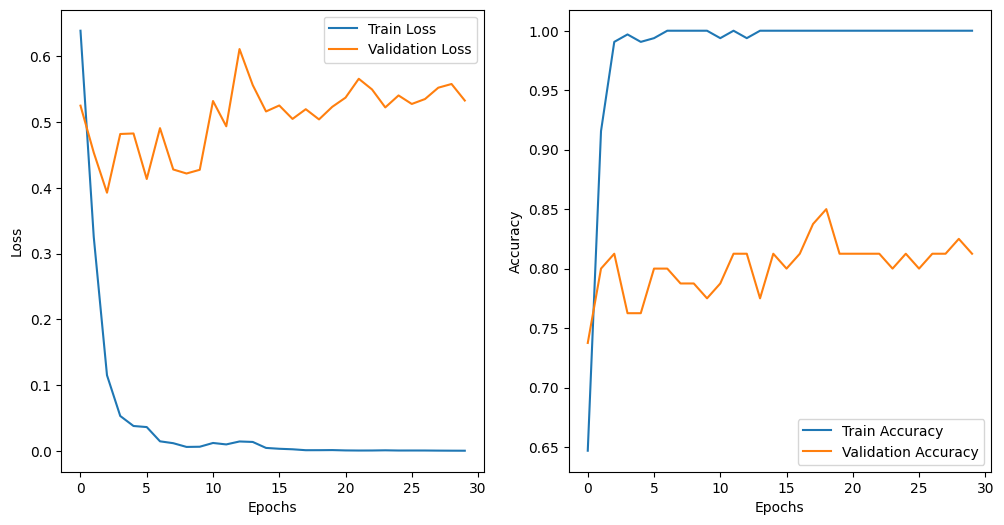

Finished Training


In [29]:
Train(model, train_loader, val_loader)

In [86]:
!tensorboard --logdir /content/logs/validation --load_fast=false


2023-09-04 07:16:01.765232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 07:16:02.643437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-04 07:16:04.039490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 07:16:04.069061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

### Accuracy, Loss Graph

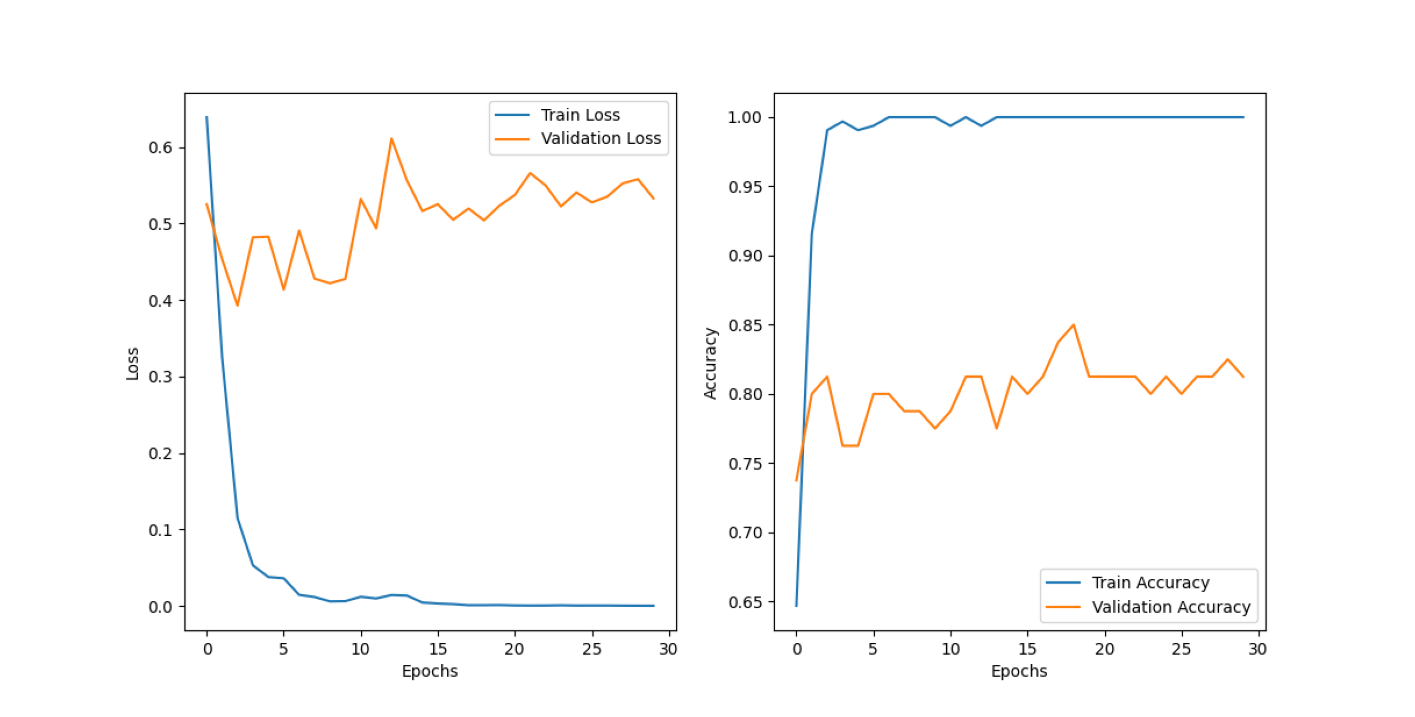

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/PLOT/matrix_2023-09-04 09:47:11.663176.png'
img = mpimg.imread(image_path)

plt.figure(figsize=(18, 10))

plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


In [33]:
def LoadCheckpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']

    return model, optimizer, epoch, loss, accuracy


### 모델 Test

### 유튜브에서 테스트 비디오 가져오기   
- pytube 이용해서 테스트 비디오 다운

In [105]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.5 MB/s eta 0:00:00


In [106]:
from pytube import YouTube

def down_youtube(down_path, url):
  yt = YouTube(url)
  yt.streams.filter(progressive=True, file_extension="mp4")\
    .order_by("resolution")\
    .desc()\
    .first()\
    .download(path)


In [140]:
url_list = ['https://youtu.be/v5aU-eSFzK4?feature=shared',
            'https://youtu.be/heKKDKHZkgM?feature=shared',
            'https://youtu.be/7l8TC79f83c?feature=shared',
            'https://youtu.be/aIo4NORQp4Y?feature=shared',
            'https://youtu.be/XrC5qgp43Q8?feature=shared',
            'https://youtu.be/whgfdxcr6Ik?feature=shared'
            ]



path = 'TEST_VIDEO'
for url in url_list:
  down_youtube(path, url)


In [34]:
base_path = '/content/TEST_VIDEO'
test_path = []
test_video = []

for dir in os.listdir('/content/TEST_VIDEO'):
  if '.ipynb_checkpoints' != dir:
    test_video.append(dir)
    test_path.append(os.path.join(base_path, dir))

test_path

['/content/TEST_VIDEO/1080p인천남동구보디빌더주차폭행사건(2023520) 원본영상블랙박스시네마.mp4',
 '/content/TEST_VIDEO/【2020 Tokyo】 TOKYO LOCAL STREET WALK 길거리 산책.mp4',
 '/content/TEST_VIDEO/남성부 주짓수 비기너 임정준 체급 1경기.mp4',
 '/content/TEST_VIDEO/Video shows fight between off-duty cop men in NYC.mp4',
 '/content/TEST_VIDEO/Hamhung North-Korea street life (북한 함흥 거리 영상).mp4',
 '/content/TEST_VIDEO/Mini Goldendoodle Puppy Gives Her Pet Dad Kisses on a Ring Cam｜RingTV.mp4']

In [35]:
test_dataset = CustomDataset(test_path, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [36]:
def Test(model, test_loader, class_mapping, device):
  model.to(device)
  model.eval()  # 모델을 평가 모드로 설정
  predicted_labels = []
  predicted_probs = []  # 예측 확률을 저장할 리스트 추가

  with torch.no_grad():
      for fast_videos, videos in tqdm(iter(test_loader)):
          fast_videos = fast_videos.to(device)
          videos = videos.to(device)

          # 모델 순전파
          outputs = model([fast_videos, videos])

          # 소프트맥스 함수를 사용하여 예측 확률 계산
          probs = torch.softmax(outputs, dim=1)

          # 가장 높은 확률을 갖는 클래스 인덱스를 추출
          _, predicted = torch.max(probs, 1)

          # 예측 결과 및 확률 저장
          predicted_labels.extend(predicted.cpu().numpy())
          predicted_probs.extend(probs.cpu().numpy())

  # 예측 결과와 확률 출력
  for i, (label, probs) in enumerate(zip(predicted_labels, predicted_probs)):
      class_name = class_mapping[label]
      print(f"videos : {test_video[i]}\n Predicted Class - {class_name}, Probability - {probs[label]:.4f}")



In [41]:
# best_path = '/content/checkpoints_2023-09-04 09:47:11.663176'
best_path = '/content/checkpoints'

checkpoint = torch.load(f'{best_path}/best.pt')
model = SlowFast(img_size=CFG['IMG_SIZE'])
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Test 결과


#### Epoch 10 - BEST.pt

videos : 1080p인천남동구보디빌더주차폭행사건(2023520) 원본영상블랙박스시네마.mp4
-  Predicted Class - Normal, Probability - 0.9045


 videos : Hamhung North-Korea street life (북한 함흥 거리 영상).mp4
-  Predicted Class - Anormaly, Probability - 0.7832

-------------

#### Epoch 30 - BEST.pt

videos : 1080p인천남동구보디빌더주차폭행사건(2023520) 원본영상블랙박스시네마.mp4
- Predicted Class - Normal, Probability - 0.9988

videos : 【2020 Tokyo】 TOKYO LOCAL STREET WALK 길거리 산책.mp4
- Predicted Class - Anormaly, Probability - 0.5709

videos : 남성부 주짓수 비기너 임정준 체급 1경기.mp4
- Predicted Class - Normal, Probability - 0.9987

videos : Hamhung North-Korea street life (북한 함흥 거리 영상).mp4
- Predicted Class - Anormaly, Probability - 0.8660


In [42]:
Test(model, test_loader, unique_label_mapping, device)

  0%|          | 0/1 [00:00<?, ?it/s]

videos : 1080p인천남동구보디빌더주차폭행사건(2023520) 원본영상블랙박스시네마.mp4
 Predicted Class - Normal, Probability - 0.9045
videos : 【2020 Tokyo】 TOKYO LOCAL STREET WALK 길거리 산책.mp4
 Predicted Class - Normal, Probability - 0.7730
videos : 남성부 주짓수 비기너 임정준 체급 1경기.mp4
 Predicted Class - Anormaly, Probability - 0.9737
videos : Video shows fight between off-duty cop men in NYC.mp4
 Predicted Class - Anormaly, Probability - 0.9554
videos : Hamhung North-Korea street life (북한 함흥 거리 영상).mp4
 Predicted Class - Anormaly, Probability - 0.7832
videos : Mini Goldendoodle Puppy Gives Her Pet Dad Kisses on a Ring Cam｜RingTV.mp4
 Predicted Class - Normal, Probability - 0.9167


In [40]:
Test(model, test_loader, unique_label_mapping, device)

  0%|          | 0/1 [00:00<?, ?it/s]

videos : 1080p인천남동구보디빌더주차폭행사건(2023520) 원본영상블랙박스시네마.mp4
 Predicted Class - Normal, Probability - 0.9988
videos : 【2020 Tokyo】 TOKYO LOCAL STREET WALK 길거리 산책.mp4
 Predicted Class - Anormaly, Probability - 0.5709
videos : 남성부 주짓수 비기너 임정준 체급 1경기.mp4
 Predicted Class - Normal, Probability - 0.9987
videos : Video shows fight between off-duty cop men in NYC.mp4
 Predicted Class - Anormaly, Probability - 0.9934
videos : Hamhung North-Korea street life (북한 함흥 거리 영상).mp4
 Predicted Class - Anormaly, Probability - 0.8660
videos : Mini Goldendoodle Puppy Gives Her Pet Dad Kisses on a Ring Cam｜RingTV.mp4
 Predicted Class - Normal, Probability - 0.9891
